In [16]:
import pandas as pd
import numpy as np
import math
import glob
import datetime
import time

In [2]:
"""
Подготовка списка датафреймов по соответствующим постам
И списка ID выбранных постов

"""

path = '/mnt/SSD/education/aspirantura/CAMELS_ru/files/hydrology/2020-09-22_15-39'
all_files = glob.glob(path + '/*_Q_Day.Cmd.txt')


In [ ]:
"""
Store Lat, Lon values as tuple with same
position as index of station
            
"""

GRDC_Stations = pd.read_excel(path + '/GRDC_Stations.xlsx')
Valid_lat_lon = list()
for j in range(len(Valid_WS)):
    for i in range(len(temporary)):    
        if Valid_WS.ID.loc[j] == temporary.grdc_no.loc[i]:
            Valid_lat_lon.append((temporary.lat.loc[i], temporary.long.loc[i]))

In [3]:
list_of_gauges = list()
list_of_station_IDS = [i[74:81] for i in all_files] # лист всех ID из представленных постов
valid_IDS = list()
for i, gauge in enumerate(all_files):
    
    """
    skip instance if it's empty
    
    """
    test = pd.read_csv(gauge, skiprows = 36, delimiter = ';', skipinitialspace = True)
    
    if test.empty:
        pass
    
    else:
        """
        read data; 
        change default column names;
        replace -999 with NaN;
        drop unnecessary column;
        add column with baseflow calculated with BFI function
        add it to list of valid time serieses 
        
        """
        test.Value = test.Value.replace(-999, np.NaN)
        test['YYYY-MM-DD'] = pd.to_datetime(test['YYYY-MM-DD'])
        test = test.drop(columns = ['hh:mm'])
        test.rename(columns = {'YYYY-MM-DD': 'Date', 'Value': 'Q'}, inplace = True)
        test['Qbase'] = np.NaN
        list_of_gauges.append(test)
        valid_IDS.append(int(list_of_station_IDS[i]))
        
print('количество постов с убранными пустышками {}, всего постов с суточными данными {}'.format(len(list_of_gauges), len(all_files)))

количество постов с убранными пустышками 211, всего постов с суточными данными 1491


In [4]:
"""
Чтение geojson
Создание списка атрибутов всех водосборов с площадью

"""

import geojson as gjs
with open(path + '/stationbasins.geojson') as f:
    WS_info = gjs.load(f)

WS_info = [i['attributes'] for i in WS_info['features']]

Valid_WS_Info = [WS_info[i] for i in range(len(WS_info)) if WS_info[i]['grdc_no'] in valid_IDS]

In [5]:
Valid_WS = pd.DataFrame(columns = {'ID', 'River_Name', 'WS_area'}) # dataframe for WS data
Valid_WS.ID = valid_IDS # assign only valuable WS with daily discharge available

temp_list_for_AREA = [[] for _ in range(len(Valid_WS.ID))] # empty list to store river name
# list of lists is used as a solution to solve .loc copy problem from df
temp_list_for_RIVER_NAME = [[] for _ in range(len(Valid_WS.ID))]

for j in range(len(Valid_WS.ID)):
    for i in range(len(Valid_WS_Info)):
        fnd = True
        while fnd:
            
            fnd = False
            
            if Valid_WS.ID.loc[j] == Valid_WS_Info[i]['grdc_no']:
                temp_list_for_AREA[j].append(Valid_WS_Info[i]['area_hys'])
                temp_list_for_RIVER_NAME[j].append(Valid_WS_Info[i]['river'] + ' - ' + Valid_WS_Info[i]['station'])
                
                fnd = True
                break
                
temp_list_for_AREA = [np.NaN if len(i) == 0 else i[0] for i in temp_list_for_AREA]
temp_list_for_RIVER_NAME = [np.NaN if len(i) == 0 else i[0] for i in temp_list_for_RIVER_NAME]

"""
Датасет сформирован таким образом, что здесь используются только те посты, 
по которым есть данные суточного стока
Расположены они в том же порядке, что и данные по расходам в
переменной

Далее, обращаясь к ID, получаем данные по площади водосбора,
которые используются дальше, при получении миллиметров слоя

"""

Valid_WS.River_Name = temp_list_for_RIVER_NAME
Valid_WS.WS_area = temp_list_for_AREA
Valid_WS = Valid_WS[[Valid_WS.columns.tolist()[1], Valid_WS.columns.tolist()[2], Valid_WS.columns.tolist()[0]]]

print('количество постов с суточными данными и площадью {}, всего постов с суточными данными {}'.format(len(Valid_WS.WS_area.dropna()), len(Valid_WS.ID.dropna())))

количество постов с суточными данными и площадью 186, всего постов с суточными данными 211


In [6]:
"""
Дальнейший расчёт будет вестись только для тех постов,
у которых есть данные о площади

"""
Valid_WS = Valid_WS.dropna().reset_index(drop = True)
Valid_gauges = [gauge for i, gauge in enumerate(list_of_gauges) if valid_IDS[i] in Valid_WS.ID.to_numpy()]

import copy

Valid_gauges_Q_mm = copy.deepcopy(Valid_gauges)

"""
calculate layer of discharge

"""

for i, gauge in enumerate(Valid_gauges_Q_mm):
    gauge.Q = 86400 * gauge.Q * 10**9 / (Valid_WS.WS_area.loc[i] * 10**12)
    


#### Функция разбивает непрерывный ряд наблюдений на отдельные года, с учётом количества NaN в году
#### На вход подаётся лист датафреймов с двумя необходимыми столбцами:
#### Date - где будет записана дата в формате datetime
#### Q - где будет записано значение расхода
#### Возвращается лист датафреймов отдельных лет, из которых выкинуты те, где количество NaN превысило лимит

In [7]:
def split_by_year(list_of_something, number_of_NaN):
    
    """
    Данная функция разбивает лист датафреймов по годам
    и выкидывает года, где NaN регулируется переменной number_of_NaN
    
    Колонка Date в датафрейме внутри листа - даты
    и она обязательна. 
    Столбцы могут называться в соответствии с пожеланиями
    
    """
    splitted_list = list()

    for i, gauge in enumerate(list_of_something):
        """
        From list of lists we are calling another list 
        that consist list of dataframes

        """
        year_split = list()
        unique_years = gauge.Date.dt.year.unique()

        for year in unique_years:
            year_split.append(gauge[gauge.Date.dt.year == year].reset_index(drop = True))

        for i in range(len(year_split)-1, -1, -1):
            if sum(year_split[i].Q.isna()) > number_of_NaN:
                del year_split[i]
            else:
                pass

        splitted_list.append(year_split)
    
    return splitted_list

### q_mean

In [194]:
every_gauge_split_by_year_mm = split_by_year(Valid_gauges_Q_mm, 0)

In [200]:
"""
После фильтрации оказалось, что некоторые годы на постах имеют в себе Большое количество пропусков

"""
Valid_gauges_Q_mean = [np.mean([np.mean(year.Q) for year in gauge]) if len(gauge) > 2 else  np.NaN for gauge in every_gauge_split_by_year_mm]
print('количество постов с рассчитанным средним {}, всего постов с суточными данными {}'.format(
    len(np.array(Valid_gauges_Q_mean)[~np.isnan(Valid_gauges_Q_mean)]),
    len(Valid_gauges_Q_mean)))

количество постов с рассчитанным средним 182, всего постов с суточными данными 186


In [68]:
CAMELS_Addor = pd.read_csv('/mnt/SSD/education/aspirantura/CAMELS_ru/literature/camels_attributes_v2.0/camels_hydro.txt', sep = ';')

In [339]:
CAMELS_Addor

,gauge_id,q_mean,runoff_ratio,slope_fdc,baseflow_index,stream_elas,q5,q95,high_q_freq,high_q_dur,low_q_freq,low_q_dur,zero_q_freq,hfd_mean
0,1013500,1.699155,0.543437,1.528219,0.585226,1.845324,0.241106,6.373021,6.10,8.714286,41.35,20.170732,0.000000,207.25
1,1022500,2.173062,0.602269,1.776280,0.554478,1.702782,0.204734,7.123049,3.90,2.294118,65.15,17.144737,0.000000,166.25
2,1030500,1.820108,0.555859,1.871110,0.508441,1.377505,0.107149,6.854887,12.25,7.205882,89.25,19.402174,0.000000,184.90
3,1031500,2.030242,0.576289,1.494019,0.445091,1.648693,0.111345,8.010503,18.90,3.286957,94.80,14.697674,0.000000,181.00
4,1047000,2.182870,0.656868,1.415939,0.473465,1.510238,0.196458,8.095148,14.95,2.577586,71.55,12.776786,0.000000,184.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,14309500,2.457700,0.493734,1.689890,0.459455,1.220096,0.057651,10.203129,41.10,4.835294,165.55,41.911392,0.000000,125.55
667,14316700,2.925937,0.643997,2.231023,0.508616,1.552484,0.141493,10.653569,16.15,2.543307,136.40,33.679012,0.000000,135.50
668,14325000,4.072283,0.646657,2.246135,0.480769,1.127976,0.104916,15.891946,23.80,3.216216,153.35,47.921875,0.000000,125.90
669,14362250,0.332015,0.119358,1.186040,0.518408,2.694495,0.000000,1.358552,33.55,9.867647,148.05,32.538462,0.088296,138.05


### slope_fdc

In [229]:
slope_hfd = []
for i, gauge in enumerate(Valid_gauges):
    if (np.nanpercentile(gauge.Q.to_numpy(), q = 100-33) > 0) & (np.nanpercentile(gauge.Q.to_numpy(), q = 100 - 66) > 0):
        slope_hfd.append((math.log(np.nanpercentile(gauge.Q.to_numpy(), q = 100-33)) - math.log(np.nanpercentile(gauge.Q.to_numpy(), q = 100-66)))/(0.66-0.33))
    else:
        slope_hfd.append(np.NaN)

### baseflow_index

#### Функции BFI_calc и BFI_calc_1000 работают Только для одномерных листов данных, приведённых к формату np.array([], dtype = np.float64)
#### В результате работы функции BFI_calc возвращается значение коэффициента BFI при заданном alpha и суточная величина фильтрованного стока на каждую дату
#### BFI_calc_1000 осуществляет расчёт BFI для alpha, равновозможно выбранного из диапазона от 0.9 до 0.98 1000 раз. 
#### Функция возвращает осредненные значения для тысячи вычислений для BFI и Qbase

In [541]:
import numba

"""
Расчёт ведётся для листа в котором нет пропусков. 
В случае их наличия в общем ряду, он разбивается
на n-рядов в зависимости от разбиений

Расчёт BFI далее будет производиться для отдельно 
взятого года наблюдений

"""
###################################################################

"""
First pass

"""
@numba.jit(nopython = True)
def FirstPass(Q, alpha):
    
    q_f_1 = [np.float64(np.NaN) for i in Q]
    q_b_1 = [np.float64(np.NaN) for i in Q]
    
    q_f_1[0] = Q[0]

    for j in range(len(Q)-1):
        """
        Для каждого куска считаем быстрый сток

        """
        q_f_1[j+1] = alpha * q_f_1[j] + 0.5 * (1 + alpha) * (Q[j+1] - Q[j])

    for j in range(len(Q)):
        if q_f_1[j] < 0:
            q_b_1[j] = Q[j]
        else:
            q_b_1[j] = Q[j] - q_f_1[j]

    Q_forward_1 = [q_f_1, q_b_1]
    
    return Q_forward_1

###################################################################
"""
Backward pass

"""
@numba.jit(nopython = True)
def BackwardPass(Q_forward_1, alpha):

    """
    Здесь Q - n-мерный лист в зависимости от числа разбиений
    """

    Qq = Q_forward_1[0]
    Qb = Q_forward_1[1]

    q_f_2 = [np.float64(np.NaN) for i in Qq]
    q_b_2 = [np.float64(np.NaN) for i in Qb]


    "последняя величина предыдущего шага - первая в обратном"
    q_f_2[-1] = Qb[-1]

    for j in range(len(Qq)-2, -1, -1):
        q_f_2[j] = alpha * q_f_2[j+1] + 0.5 * (1 + alpha) * (Qb[j] - Qb[j+1])

    for j in range(len(Qq)-1, -1, -1):
        if q_f_2[j] < 0:
            q_b_2[j] = Qb[j]
        else:
            q_b_2[j] = Qb[j] - q_f_2[j]
                
    Q_backward = [q_f_2, q_b_2]

    return Q_backward

###################################################################
"""
Forward pass

"""
@numba.jit(nopython = True)
def ForwardPass(Q_backward, alpha):

    Qq = Q_backward[0]
    Qb = Q_backward[1]

    q_f_3 = [np.float64(np.NaN) for i in Qq]
    q_b_3 = [np.float64(np.NaN) for i in Qb]


    "Теперь первая величина предыдущего шага - первая и здесь"

    q_f_3[0] = Qb[0]

    for j in range(len(Qb)-1):

        q_f_3[j+1] = alpha * q_f_3[j] + 0.5 * (1 + alpha) * (Qb[j+1] - Qb[j])

    for j in range(len(Qb)):
        if q_f_3[j] < 0:
            q_b_3[j] = Qb[j]
        else:
            q_b_3[j] = Qb[j] - q_f_3[j]

    Q_forward = [q_f_3, q_b_3]

    return Q_forward

###################################################################
"""
BFI calculations for given alpha

"""
@numba.jit(nopython = True)
def BFI_calc(Q, alpha, passes, reflect):
    """
    we reflect the first reflect values and the last reflect values.  
    this is to get rid of 'warm up' problems © Anthony Ladson
    """ 
    Qin = Q
    
    "отложим отраженные величины с конца и начала нашего ряда"
    
    if len(Q)-1 > reflect:
        Q_reflect = np.array([np.float64(np.NaN) for _ in range(len(Q) + 2 * reflect)], dtype = np.float64)

        Q_reflect[:reflect] = Q[(reflect):0:-1]
        Q_reflect[(reflect):(reflect + len(Q))] = Q
        Q_reflect[(reflect + len(Q)):(len(Q) + 2 + 2 * reflect)] = Q[len(Q)-2:len(Q) - reflect - 2:-1]
        
    else:        
        Q_reflect = np.array([np.float64(np.NaN) for _ in range(len(Q))], dtype = np.float64)                 
        Q_reflect = Q
    
    Q1 = FirstPass(Q_reflect, alpha)

    "how many backwards/forward passes to we need © Anthony Ladson"

    n_pass = round(0.5 * (passes -1))

    BackwardPass(Q1, alpha)

    for i in range(n_pass):
        Q1 = ForwardPass(BackwardPass(Q1, alpha), alpha)

    ################# end of passes  ##############################
    if len(Q)-1 > reflect:
        Qbase = Q1[1][reflect:(len(Q1[1])-reflect)]
        Qbase = [0 if j < 0 else j for j in Qbase]
    else:
        Qbase = Q1[1]
        Qbase = [0 if j < 0 else j for j in Qbase]

    bfi = 0
    mean_for_period = 0
    
    if np.mean(Qin) == 0:
        bfi = 0
    else:
        for j in Qbase:
            mean_for_period += j/np.mean(Qin)
        bfi = mean_for_period/len(Qbase)

    return bfi, Qbase

"""
BFI calculations for 1000 alpha between 0.9 and 0.98

"""

import random
@numba.jit(nopython = True)
def BFI_calc_1000(Q, passes, reflect):
    """
    Расчёт проводится для 1000 случайных значений alpha
    в диапазоне он 0.9 до 0.98
    
    we reflect the first reflect values and the last reflect values.  
    this is to get rid of 'warm up' problems © Anthony Ladson
    """ 
    
    random.seed(1996)
    alpha_coefficients = [np.float64(random.uniform(0.9, 0.98)) for i in range(1000)]
    
    Q = np.array([np.float64(i) for i in Q], dtype = np.float64)
    Qin = Q
    
    "отложим отраженные величины с конца и начала нашего ряда"
    
    if len(Q)-1 > reflect:
        Q_reflect = np.array([np.float64(np.NaN) for _ in range(len(Q) + 2 * reflect)], dtype = np.float64)

        Q_reflect[:reflect] = Q[(reflect):0:-1]
        Q_reflect[(reflect):(reflect + len(Q))] = Q
        Q_reflect[(reflect + len(Q)):(len(Q) + 2 + 2 * reflect)] = Q[len(Q)-2:len(Q) - reflect - 2:-1]
        
    else:        
        Q_reflect = np.array([np.float64(np.NaN) for _ in range(len(Q))], dtype = np.float64)                 
        Q_reflect = Q
    
    bfi_record = []
    Qbase_record = []
    
    for i, alpha in enumerate(alpha_coefficients):
        
        Q1 = FirstPass(Q_reflect, alpha)

        "how many backwards/forward passes to we need © Anthony Ladson"

        n_pass = round(0.5 * (passes -1))

        BackwardPass(Q1, alpha)

        for i in range(n_pass):
            Q1 = ForwardPass(BackwardPass(Q1, alpha), alpha)
        

        ################# end of passes  ##############################
        if len(Q)-1 > reflect:
            Qbase = Q1[1][reflect:(len(Q1[1])-reflect)]
            Qbase = [0 if j < 0 else j for j in Qbase]
        else:
            Qbase = Q1[1]
            Qbase = [0 if j < 0 else j for j in Qbase]
        
        Qbase_record.append(np.array(Qbase, dtype=np.float64))
        
        bfi = 0
        mean_for_period = 0

        if np.mean(Qin) == 0:
            bfi = 0
        else:
            for j in Qbase:
                mean_for_period += j/np.mean(Qin)
            bfi = mean_for_period/len(Qbase)
            
        bfi_record.append(np.float64(bfi))
        
    """
    Поcле расчёта 1000 значений BFI
    функция возвращает среднее значение из тысячи
    
    И средний гидрограф из тысячи гидрографов Qbase
    
    """
    
    #средний BFI из тысячи
    
    bfi_mean = 0
    for i in bfi_record:
        bfi_mean += i
    bfi_mean = bfi_mean/len(bfi_record)
    
    # средний гидрограф из тысячи

    Qbase_mean = [np.float64(0) for i in range(len(Qbase))]
    
    for Qbase_temp in Qbase_record:
        for i, value in enumerate(Qbase_temp):
            Qbase_mean[i] += value
    
    Qbase_mean = [np.float64(i/len(Qbase_record)) for i in Qbase_mean]
        
    return bfi_mean, Qbase_mean

### проверка на базовом датасете Anthony Ladson

In [9]:
import requests
import csv
url = "https://raw.github.com/TonyLadson/data/master/data/BassRiver@Loch.csv"

with requests.Session() as s:
    download = s.get(url)

    decoded_content = download.content.decode('utf-8')

    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(cr)

my_list = [np.float64(i[0]) for i in my_list]

In [542]:
t = BFI_calc_1000(np.array(my_list, dtype = np.float64), 3, 30)
t1 = BFI_calc(np.array(my_list, dtype = np.float64), 0.98, 3, 30)
print('BFI on random values from 0.9 to 0.98 = {}, BFI on alpha 0.98 = {}'.format(t[0], t1[0]))

BFI on random values from 0.9 to 0.98 = 0.35213351185633607, BFI on alpha 0.98 = 0.1965758714772886


#### Given function split one array with NaN's to several arrays without NaN's depends on number of NaN intervals
#### If there's no NaN exist in array It'll return nested array with original one

In [11]:
def clump_array(a):

    """
    Разбить период наблюдений на куски, в которых нет NaN
    """

    return [np.float64(a[s]) for s in np.ma.clump_unmasked(np.ma.masked_invalid(a))]

In [12]:
clump_test = np.array([1, 2, 3, np.NaN, np.NaN, 5, 6, 6, np.NaN, 3, 4])
clump_array(clump_test)

[array([1., 2., 3.]), array([5., 6., 6.]), array([3., 4.])]

In [13]:
clump_test_2 = [1, 2, 3, 4, 5, 6]
clump_array(clump_test_2)

[array([1., 2., 3., 4., 5., 6.])]

#### Разбитие непрерывных рядов наблюдений постов,
#### у которых есть площади и есть ряды суточных наблюдений
#### на лист датафреймов с тремя колонками
#### Date, Q, Qbase. Где Q - сток в cms. Qbase - грунтовая составляющая, расчитанная по BFI

In [134]:
every_gauge_split_by_year = split_by_year(Valid_gauges, 60)
every_gauge_split_by_year_np = [[clump_array(year.Q.to_numpy()) for year in gauge] for gauge in every_gauge_split_by_year]

#### Расчёт BFI при alpha выбранных равновозможно из диапазона от 0.925 до 0.98 
#### В листы листов сохраняются временные значения, которые необходимы для дальнейшего расчёта:
#### clump_bfi, weights_of_clump - для взвешенного значения BFI на посту за период наблюдений
#### clump_Qbase - для расчёта грунтовой составляющей

In [543]:
clump_bfi = [[[[] for clump in year]  for year in gauge] for gauge in every_gauge_split_by_year_np]
weights_of_clump = [[[[] for clump in year]  for year in gauge] for gauge in every_gauge_split_by_year_np]
clump_Qbase = [[[[] for clump in year]  for year in gauge] for gauge in every_gauge_split_by_year_np]

for i, gauge in enumerate(every_gauge_split_by_year_np):
    start = time.time()
    for j, year in enumerate(gauge):
        for k, clump in enumerate(year):
            # проверка, что кусок между NaN больше, длины сравнения
            if type(clump) == np.ndarray:
                clump_bfi[i][j][k] = BFI_calc_1000(clump, 3, 30)[0]
                weights_of_clump[i][j][k] = len(clump)/len(every_gauge_split_by_year[i][j].Q)
                clump_Qbase[i][j][k] = BFI_calc_1000(clump, 3, 30)[1]
            else:
                clump_bfi[i][j][k] = np.NaN
                weights_of_clump[i][j][k] = np.NaN
                clump_Qbase[i][j][k] = [np.NaN]
    stop = time.time()
    print('итерация {} закончилась за {} секунд'.format(i, round(stop - start)))

итерация 0 закончилась за 10 секунд
итерация 1 закончилась за 15 секунд
итерация 2 закончилась за 3 секунд
итерация 3 закончилась за 13 секунд
итерация 4 закончилась за 3 секунд
итерация 5 закончилась за 2 секунд
итерация 6 закончилась за 3 секунд
итерация 7 закончилась за 12 секунд
итерация 8 закончилась за 21 секунд
итерация 9 закончилась за 3 секунд
итерация 10 закончилась за 8 секунд
итерация 11 закончилась за 17 секунд
итерация 12 закончилась за 9 секунд
итерация 13 закончилась за 3 секунд
итерация 14 закончилась за 3 секунд
итерация 15 закончилась за 3 секунд
итерация 16 закончилась за 3 секунд
итерация 17 закончилась за 3 секунд
итерация 18 закончилась за 3 секунд
итерация 19 закончилась за 3 секунд
итерация 20 закончилась за 15 секунд
итерация 21 закончилась за 8 секунд
итерация 22 закончилась за 3 секунд
итерация 23 закончилась за 3 секунд
итерация 24 закончилась за 4 секунд
итерация 25 закончилась за 3 секунд
итерация 26 закончилась за 3 секунд
итерация 27 закончилась за 17 с

#### BFI CALCULATION

In [544]:
weighted_bfi = [np.mean([np.sum([bfi * weights_of_clump[i][j][k] for k, bfi in enumerate(year)]) for j, year in enumerate(gauge)]) if len(gauge) > 2 else np.NaN for i, gauge in enumerate(clump_bfi)]

In [306]:
pd.DataFrame(clump_Qbase).to_csv("clump_Qbase.csv")
pd.DataFrame(weights_of_clump).to_csv("weights_of_clump.csv")
pd.DataFrame(clump_bfi).to_csv("clump_bfi.csv")

#### This function takes two arguments:
#### Given array with NaN's or without them
#### If NaN exists it split's array to number of arrays depended on number of NaN intervals
#### and create mask with boolean value for every array:
#### If split consist NaN it'll be marked with False, otherwise - True
#### This function allows to rebuild BFI calculations to the equal length of given array, considering NaN's in original one

In [307]:
from itertools import groupby
def bfi_recover(year_of_observation, bfi_values):
    
    """
    Восстановления ряда baseflow с учётом ранее "выбитых" пропусков
    """
    Qbase_full = [list(group) for key, group in groupby(year_of_observation.Q.to_numpy(), key=np.isnan)] # разбитие на группы по признаку. Получается n листов. NaN и !NaN разбиты по листам
    mask_to_refill = [~np.isnan(i).any() for i in Qbase_full] # индексируем их как одинокие булевые величины

    position_index = -1
    for j, mask in enumerate(mask_to_refill):
        """
        Так как первичный разрезанный лист из функции clumped_array имеет в себе количество листов, такое же как и True, то восстанавливаем в соответствии

        Аргумент position_index подбирается в соответствии с присутсвием с True и адресуется к нужному куску в Qbase

        Всё перезаписывается в лист, где в перезаписываемых значениях эквивалентные по длине значения стока
        """
        if len(Qbase_full) > 1:
            if mask:
                position_index += 1
                Qbase_full[j] = bfi_values[position_index]
            else:
                position_index = position_index
                Qbase_full[j] = Qbase_full[j]
        else:
            Qbase_full[j] = [item for sublist in bfi_values for item in sublist]
            
    if len(Qbase_full) > 1:
        Qbase_full = [item for sublist in Qbase_full for item in sublist] # лист листов в лист с учётом NaN
    else:
        Qbase_full = [item for sublist in Qbase_full for item in sublist]
    
    return Qbase_full

#### Заполнение столбца Qbase восстанавливая разбитые на куски без NaN наблюдения за стоком

In [308]:
for i, gauge in enumerate(every_gauge_split_by_year_np):
    for j, year in enumerate(gauge):
        for k, clump in enumerate(year):
            every_gauge_split_by_year[i][j].Qbase = bfi_recover(every_gauge_split_by_year[i][j], clump_Qbase[i][j])

#### Сохранение данных для предварительного анализа

In [309]:
import re

WS_names = [re.sub('[/]', '', Valid_WS.River_Name[i]) for i in range(len(Valid_WS))]
year_of_observation = [[str(int(year.Date.dt.year.unique())) for year in gauge] for gauge in every_gauge_split_by_year]
names_for_files = [[WS_names[i] + ' ' + year for year in year_of_observation[i]] for i in range(len(WS_names))]

In [311]:
folder = 'Qbase_data'
import os
if not os.path.exists(folder):
    os.makedirs(folder)
    
for i, gauge in enumerate(every_gauge_split_by_year):
    for j, year in enumerate(gauge):
        year.to_csv(folder + '/' + names_for_files[i][j] + '.csv')

#### Пример проблемного графика с промежутком пропусков

<AxesSubplot:xlabel='Date'>

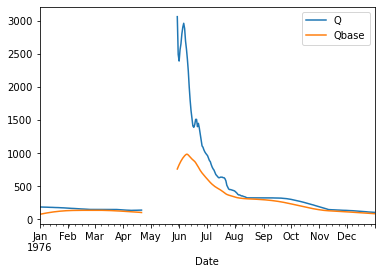

In [312]:
every_gauge_split_by_year[0][19].set_index('Date').plot()

<AxesSubplot:xlabel='Date'>

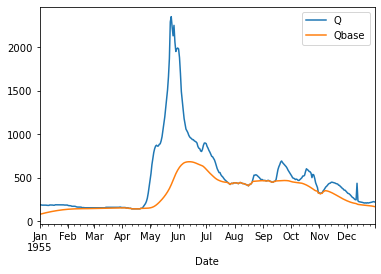

In [313]:
every_gauge_split_by_year[0][0].set_index('Date').plot()

#### BFI without numba support

In [11]:
"Создаём отдельные вектора в соответствии с разбиением на куски без NaN"

###################################################################


def FirstPass(Q, alpha):

    q_f_1 = [[[] for _ in range(len(i))] for i in Q]
    q_b_1 = [[[] for _ in range(len(i))] for i in Q]

    for i in range(len(Q)):           
        """
        Задаём первые величины векторе "быстрого" стока

        """
        q_f_1[i][0] = Q[i][0]

        for j in range(len(Q[i])-1):
            """
            Для каждого куска считаем быстрый сток

            """
            q_f_1[i][j+1] = alpha * q_f_1[i][j] + 0.5 * (1 + alpha) * (Q[i][j+1] - Q[i][j])

        for j in range(len(Q[i])):
            if q_f_1[i][j] < 0:
                q_b_1[i][j] = Q[i][j]
            else:
                q_b_1[i][j] = Q[i][j] - q_f_1[i][j]
    
    Q_forward_1 = [q_f_1, q_b_1]
    
    return q_f_1, q_b_1

###################################################################

def BackwardPass(Q_forward_1, alpha):

    """
    Здесь Q - n-мерный лист в зависимости от числа разбиений
    """

    Qq = Q_forward_1[0]
    Qb = Q_forward_1[1]

    q_f_2 = [[[] for _ in range(len(i))] for i in Qq]
    q_b_2 = [[[] for _ in range(len(i))] for i in Qb]

    for i in range(len(Qq)):
        "последняя величина предыдущего шага - первая в обратном"
        q_f_2[i][-1] = Qb[i][-1]

        for j in range(len(Qq[i])-2, -1, -1):
            q_f_2[i][j] = alpha * q_f_2[i][j+1] + 0.5 * (1 + alpha) * (Qb[i][j] - Qb[i][j+1])

        for j in reversed(range(len(Qq[i]))):
            if q_f_2[i][j] < 0:
                q_b_2[i][j] = Qb[i][j]
            else:
                q_b_2[i][j] = Qb[i][j] - q_f_2[i][j]
    Q_backward = [q_f_2, q_b_2]

    return Q_backward

###################################################################

def ForwardPass(Q_backward, alpha):

    Qq = Q_backward[0]
    Qb = Q_backward[1]

    q_f_3 = [[[] for _ in range(len(i))] for i in Qq]
    q_b_3 = [[[] for _ in range(len(i))] for i in Qb]

    for i in range(len(Qq)):

        "Теперь первая величина предыдущего шага - первая и здесь"

        q_f_3[i][0] = Qb[i][0]

        for j in range(len(Qb[i])-1):

            q_f_3[i][j+1] = alpha * q_f_3[i][j] + 0.5 * (1 + alpha) * (Qb[i][j+1] - Qb[i][j])

        for j in range(len(Qb[i])):
            if q_f_3[i][j] < 0:
                q_b_3[i][j] = Qb[i][j]
            else:
                q_b_3[i][j] = Qb[i][j] - q_f_3[i][j]

    Q_forward = [q_f_3, q_b_3]

    return Q_forward

###################################################################

def BFI_calc(Q, alpha, passes, reflect):
    """
    we reflect the first reflect values and the last reflect values.  
    this is to get rid of 'warm up' problems © Anthony Ladson
    """ 
    
    Qin = Q
    
    "отложим отраженные величины с конца и начала нашего ряда"
    Q_reflect = [[[] for _ in range(len(i) + 2 * reflect)] for i in Q]

    for i in range(len(Q_reflect)):

        Q_reflect[i][:reflect] = Q[i][(reflect):0:-1] #добавляем 

        Q_reflect[i][(reflect):(reflect + len(Q[i]))] = Q[i]

        Q_reflect[i][(reflect + len(Q[i])):(len(Q[i]) + 2 + 2 * reflect)] = Q[i][len(Q[i])-2:len(Q[i]) - reflect - 2:-1]
    
    Q1 = FirstPass(Q_reflect, alpha)

    "how many backwards/forward passes to we need © Anthony Ladson"

    n_pass = round(0.5 * (passes -1))

    BackwardPass(Q1, alpha)

    for i in range(n_pass):
        Q1 = ForwardPass(BackwardPass(Q1, alpha), alpha)

    ################# end of passes  ##############################
    
    Qbase = [i[reflect:(len(i)-reflect)] for i in Q1[1]]
    Qbase = [[0 if j < 0 else j for j in i] for i in Qbase]
    
    # расчёт взвешенного среднего для разбитого на куски ряда расходов
    
    len_Qbase = len([item for sublist in Qbase for item in sublist]) # длина всех расходов, без учёта пропусков
    weights_for_average = [len(i)/len_Qbase for i in Qbase] # вес для среднего по каждому элементу
    
    weighted_bfi = np.sum([weights_for_average[i] * np.nanmean(Qbase[i]/np.nanmean(Qin[i])) if np.nanmean(Qin[i]) != 0 else weights_for_average[i] * 0 for i in range(len(Qbase))]) #взвешенное среднее по выпуклой комбинации

    return weighted_bfi, Qbase

#### hfd_mean
#### mean half-flow date (date on which the cumulative discharge since start of the year reaches half of the annual discharge)

In [182]:
every_gauge_split_by_year_hfd = split_by_year(Valid_gauges_Q_mm, 0)
hfd = [[[] for year in gauge] for gauge in every_gauge_split_by_year_hfd]

In [183]:
for i in trange(len(every_gauge_split_by_year_hfd)):
    for j, year in enumerate(every_gauge_split_by_year_hfd[i]):
        half_discharge = 0
        for k, discharge in enumerate(year.Q.to_numpy()):
            half_discharge += discharge
            if half_discharge > year.Q.sum()/2:
                break
        hfd[i][j].append(half_discharge)
            
hfd_mean = [np.mean(gauge) if len(gauge) > 2 else np.NaN for gauge in hfd]
        
        

100%|██████████| 186/186 [00:38<00:00,  4.83it/s]


#### Q5
#### 5 % flow quantile (low flow)




In [335]:
Q5 = [np.nanpercentile(gauge.Q.to_numpy(), q = 5) for gauge in Valid_gauges_Q_mm]

#### Q95
#### 95 % flow quantile (high flow)

In [337]:
Q95 = [np.nanpercentile(gauge.Q.to_numpy(), q = 95) for gauge in Valid_gauges_Q_mm]

#### high_q_freq
#### frequency of high-flow days (> 9 times the median daily flow)

In [350]:
high_q_f = [np.mean([len(year[year.Q > year.Q.median()*9]) for year in gauge]) if len(gauge) > 2 else np.NaN for gauge in every_gauge_split_by_year_mm]

#### high_q_dur
#### average duration of high-flow events (number of consecutive days > 9 times the median daily flow)

In [518]:
high_q_dur = [[[len(i) for i in [year.Q[s] for s in np.ma.clump_unmasked(np.ma.masked_where(year.Q < year.Q.median()*9, year.Q))]] for year in gauge] if len(gauge) > 2 else [[np.NaN]] for gauge in every_gauge_split_by_year_mm]

for i, gauge in enumerate(high_q_dur):
    for j, year in enumerate(gauge):
        if len(year) == 0:
            high_q_dur[i][j] = 0
        else:
            high_q_dur[i][j] = year[0]
high_q_dur = [np.mean(i) for i in high_q_dur]

#### low_q_freq
### frequency of low-flow days (< 0.2 times the mean daily flow)

In [519]:
low_q_freq = [np.mean([len(year[year.Q < year.Q.mean()*0.2]) for year in gauge]) if len(gauge) > 2 else np.NaN for gauge in every_gauge_split_by_year_mm]

#### low_q_dur
#### average duration of low-flow events (number of consecutive days < 0.2 times the mean daily flow)

In [520]:
low_q_dur = [[[len(i) for i in [year.Q[s] for s in np.ma.clump_unmasked(np.ma.masked_where(year.Q > year.Q.mean()*0.2, year.Q))]] for year in gauge] if len(gauge) > 2 else [[np.NaN]] for gauge in every_gauge_split_by_year_mm]

for i, gauge in enumerate(low_q_dur):
    for j, year in enumerate(gauge):
        if len(year) == 0:
            low_q_dur[i][j] = 0
        else:
            low_q_dur[i][j] = year[0]
low_q_dur = [np.mean(i) for i in low_q_dur]

#### zero_q_freq
#### frequency of days with Q = 0

In [537]:
zero_q_freq = [np.mean([sum(year.Q == 0)/len(year.Q) for year in gauge]) if len(gauge) > 2 else np.NaN for gauge in every_gauge_split_by_year_mm]

In [589]:
camels_ru_hydro = pd.DataFrame(data = [Valid_WS.ID.to_numpy(), Valid_gauges_Q_mean, slope_hfd, weighted_bfi, hfd_mean, Q5, Q95, high_q_f, high_q_dur, low_q_freq, low_q_dur, zero_q_freq])
camels_ru_hydro = camels_ru_hydro.T
camels_ru_hydro.columns = ['ID', 'Q_mean', 'slope_hfd', 'bfi', 'hfd_mean', 'Q5', 'Q95', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'low_q_dur', 'zero_q_freq']
camels_ru_hydro = camels_ru_hydro.applymap('{:.2f}'.format)
camels_ru_hydro.ID = Valid_WS.ID.to_numpy()

path_to_results = '/mnt/SSD/education/aspirantura/CAMELS_ru/code/camels_ru/results/'
camels_ru_hydro.to_csv(path_to_results + 'camels_ru_hydro.csv', sep = ';', index = False)